In [84]:
# based on clonealign framework, re-write with pyro
import os
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
import scipy.stats
from torch.distributions import constraints
from torch.nn import Softplus
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)

In [85]:
# input data

expr_input = "data/expr_simulated_0.csv"
cnv_input = "data/SPECTRUM-OV-022_cnv_clonealign_input.csv"

clone_assign_prob_output = "data/SPECTRUM-OV-022_clone_assign_prob_0.csv"
gene_type_score_output = "data/SPECTRUM-OV-022_gene_type_score_0.csv"



In [86]:

expr_csv = pd.read_csv(expr_input, header = 0, index_col=0)
cnv_csv = pd.read_csv(cnv_input, header = 0, index_col=0)

expr_csv = expr_csv[expr_csv.mean(1) > 0]
cnv_csv = cnv_csv.loc[expr_csv.index, ]

# cast cnv greater than 6
cnv = torch.tensor(cnv_csv.values, dtype=torch.float)
cnv = torch.transpose(cnv, 0, 1)

cnv[cnv > 6] = 6

expr = torch.tensor(expr_csv.values, dtype = torch.float)
expr = torch.transpose(expr, 0, 1)



In [87]:
cnv

tensor([[2., 2., 2.,  ..., 2., 2., 2.],
        [2., 2., 2.,  ..., 2., 2., 2.],
        [3., 3., 3.,  ..., 3., 3., 3.]])

In [88]:
# input data: cnv, expr
# cnv: clone_count * gene_count
# expr: cell_count * gene_count
def inverse_softplus(x):
    return x + torch.log(-torch.expm1(-x))

@config_enumerate
def clonealign_pyro(cnv, expr):
    num_of_clones = len(cnv)
    num_of_cells = len(expr)
    num_of_genes = len(expr[0])

    softplus = Softplus()

    # initialize per_copy_expr using the data (This typically speeds up convergence)
    expr = expr * 2000 / torch.reshape(torch.sum(expr, 1), (num_of_cells, 1))
    per_copy_expr_guess = torch.mean(expr, 0)

    # calculate copy number mean
    copy_number_mean = torch.mean(cnv, 0)

    # draw chi from gamma
    chi = pyro.sample('chi', dist.Gamma(torch.ones(6) * 2, torch.ones(6)).to_event(1))

    with pyro.plate('gene', num_of_genes):
        # draw per_copy_expr from softplus-transformed Normal distribution
        per_copy_expr = pyro.sample('per_copy_expr',
                                    dist.Normal(inverse_softplus(per_copy_expr_guess), torch.ones(num_of_genes)))
        per_copy_expr = softplus(per_copy_expr)
        
        # instead of softplus-transformed normal, use negative binomial instead for per_copy_expr
        # per_copy_expr = pyro.sample('per_copy_expr', dist.NegativeBinomial())

        # draw w from Normal
        w = pyro.sample('w', dist.Normal(torch.zeros(6), torch.sqrt(chi)).to_event(1))

        # sample the gene_type_score from uniform distribution.
        # the score reflects how much the copy number influence expression.
        gene_type_score = pyro.sample('gene_type_score', dist.Dirichlet(torch.ones(2) * 0.1))

    #gene_type = pyro.sample('gene_type', dist.Bernoulli(probs = gene_type_score))

    with pyro.plate('cell', num_of_cells):
        # draw clone_assign_prob from Dir
        clone_assign_prob = pyro.sample('clone_assign_prob', dist.Dirichlet(torch.ones(num_of_clones)))
        # draw clone_assign from Cat
        clone_assign = pyro.sample('clone_assign', dist.Categorical(clone_assign_prob))

        # draw psi from Normal
        psi = pyro.sample('psi', dist.Normal(torch.zeros(6), torch.ones(6)).to_event(1))        

        expected_expr = per_copy_expr * (
                    Vindex(cnv)[clone_assign] * gene_type_score[:, 0] + copy_number_mean * gene_type_score[:, 1]) * torch.exp(
            torch.matmul(psi, torch.transpose(w, 0, 1)))

        # draw expr from Multinomial
        pyro.sample('obs', dist.Multinomial(total_count = 2000, probs=expected_expr, validate_args=False), obs=expr)
        
        

In [89]:
# initialize Adam optimizer
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})

# TraceEnum_ELBO will marginalize out the assignments of datapoints to clusters
elbo = TraceEnum_ELBO(max_plate_nesting=1)

pyro.clear_param_store()

# AutoGuide
global_guide = AutoDelta(poutine.block(clonealign_pyro, \
                                       expose = ['chi', 'per_copy_expr', 'w', 'gene_type_score', \
                                                 'clone_assign_prob', 'psi']))
# put together SVI object
svi = SVI(clonealign_pyro, global_guide, optim, loss=elbo)

In [90]:
gradient_norms = defaultdict(list)
svi.loss(clonealign_pyro, global_guide, cnv, expr)  # Initializes param store.

12180554.0

In [91]:
losses = []
max_iter = 200
rel_tol = 1e-5
print('Start Inference.')
for i in range(max_iter if not smoke_test else 2):
    loss = svi.step(cnv, expr)
    
    if i >= 1:
        loss_diff = abs((losses[-1] - loss)/losses[-1])
        if loss_diff < rel_tol:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    
    print('.' if i % 200 else '\n', end='')

Start Inference.

.........................................................................................................................................................................ELBO converged at iteration 170


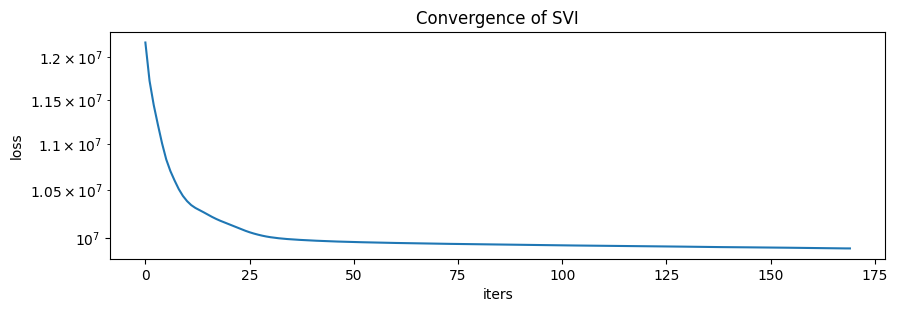

In [92]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [93]:
map_estimates = global_guide(cnv, expr)

clone_assign_prob = map_estimates['clone_assign_prob']
gene_type_score = map_estimates['gene_type_score']

per_copy_expr = map_estimates['per_copy_expr']
psi = map_estimates['psi']
chi = map_estimates['chi']
w = map_estimates['w']

clone_assign_prob_dataframe = pd.DataFrame(clone_assign_prob.data.numpy())
gene_type_score_dataframe = pd.DataFrame(gene_type_score.data.numpy())

In [98]:
rowname_dict = {i:c for i, c in enumerate(expr_csv.columns)}
colname_dict = {i:c for i, c in enumerate(cnv_csv.columns)}

genename_dict = {i:c for i, c in enumerate(expr_csv.index)}

clone_assign_prob_dataframe.rename(index = rowname_dict, inplace = True)
clone_assign_prob_dataframe.rename(columns = colname_dict, inplace = True)

gene_type_score_dataframe.rename(index = genename_dict, inplace = True)

In [95]:
clone_assign_prob_dataframe.to_csv(clone_assign_prob_output)

In [99]:
gene_type_score_dataframe.to_csv(gene_type_score_output)

In [97]:
clone_assign_prob_dataframe

,cluster_1,cluster_2,cluster_3
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,0.001882,0.001882,0.996236
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,0.001812,0.992513,0.005675
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,0.993030,0.001726,0.005245
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,0.002529,0.992621,0.004851
SPECTRUM-OV-022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,0.992671,0.001802,0.005527
...,...,...,...
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCCATGACTGT,0.001882,0.001882,0.996236
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,0.001882,0.001882,0.996236
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,0.994324,0.001688,0.003987
SPECTRUM-OV-022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,0.001882,0.001882,0.996236


In [76]:
clone_assign_prob_dataframe

,clone1,clone2,clone3,clone4
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,0.001993,0.001993,0.001993,0.994020
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,0.994020,0.001993,0.001993,0.001993
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,0.984887,0.008323,0.001852,0.004938
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,0.994020,0.001993,0.001993,0.001993
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,0.994020,0.001993,0.001993,0.001993
...,...,...,...,...
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,0.001993,0.001993,0.001993,0.994020
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGGAGGTGTGTGTT,0.002184,0.001989,0.993905,0.001921
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,0.001996,0.002081,0.002011,0.993913
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,0.001983,0.001992,0.994061,0.001964
